## Occlusion Map Generator

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage

import time

from copy import deepcopy

In [2]:
import tensorflow.keras as keras

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [3]:
import pickle

In [4]:
import tensorflow as tf

print(tf.__version__)

1.14.0


In [5]:
tipo = 3    #change type of image (0 to 3)


# ========== EXTRACCIÓN DE DATOS ==============
archivo = open('./dataset/HiTS2013_100k_samples(4_channels)_images_labels.pkl',"rb")
example_dict= pickle.load(archivo)
print('Dimension of labels: N=',example_dict['labels'].shape[0])
print('Dimension of images:',example_dict['images'].shape)

L=example_dict['labels'].shape[0] #numero total de imagenes

Dimension of labels: N= 100000
Dimension of images: (100000, 21, 21, 4)


In [6]:
x_all=example_dict['images']
x_all_padded=np.pad(x_all, ((0,0),(3,3), (3,3), (0, 0)), 'constant')
print(x_all_padded.shape)

(100000, 27, 27, 4)


In [7]:
percentage_train=0.9   #how much do you want to use?

percentage= int(percentage_train*L)
xx_= x_all[:, :, :, tipo] #
xx = x_all_padded[:, :, :, tipo]
yy= example_dict['labels']
print('Dimension of images to train:',xx[:percentage].shape)
print('Dimension of images to test:',xx[percentage:].shape)
print('Number of images to train: ', yy[:percentage].shape[0])
print('Number of images to test: ',yy[percentage:].shape[0])

#database to train
x_train=xx[:percentage]
y_train=yy[:percentage]
x_train_=xx_[:percentage]#

#database to test
x_test=xx_[percentage:]
y_test=yy[percentage:]

#input shape para las redes convolucionales
input_shape1=x_test.shape[1]
input_shape2=x_test.shape[2]
print('\n\ninput_shape (2D): ' , input_shape1, 'x', input_shape2)

input_shape = (input_shape1, input_shape2, 1)
print('\n\ninput_shape (3D): ' , input_shape)

Dimension of images to train: (90000, 27, 27)
Dimension of images to test: (10000, 27, 27)
Number of images to train:  90000
Number of images to test:  10000


input_shape (2D):  21 x 21


input_shape (3D):  (21, 21, 1)


In [8]:
# Reshape the images.
r_x_train= np.expand_dims(x_train, axis=3)
r_x_test = np.expand_dims(x_test, axis=3)
r_x_train_= np.expand_dims(x_train_, axis=3)


print('r_x_train', r_x_train.shape)
print('r_x_test', r_x_test.shape)
print('r_x_train_', r_x_train_.shape)

r_x_train (90000, 27, 27, 1)
r_x_test (10000, 21, 21, 1)
r_x_train_ (90000, 21, 21, 1)


In [9]:
x_train_all=x_all[:percentage]
x_test_all=x_all[percentage:]
input_shape=x_train_all[0].shape
print(x_train_all.shape)
print(x_test_all.shape)
print(x_train_all[0].shape)

(90000, 21, 21, 4)
(10000, 21, 21, 4)
(21, 21, 4)


In [10]:
## Some useful functions

def to_3_axis(im_2d):
    im_3d = np.expand_dims(im_2d, axis=3)
    return im_3d

def to_4_axis(im_3d):
    im_4d = np.expand_dims(im_3d, axis=0)
    return im_4d    

def d2_to_d4(d2):
    d3=np.expand_dims(d2, axis=0)
    d4=np.expand_dims(d3, axis=-1)
    return d4


In [11]:
#normalization
def normalize(processed):
    ####### calculate global mean and standard deviation
    mean, std = processed.mean(), processed.std()
    #print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    ####### global standardization of pixels
    processed = (processed - mean) / std
    ####### clip pixel values to [-1,1]
    processed = np.clip(processed, -1.0, 1.0)
    ####### shift from [-1,1] to [0,1] with 0.5 mean
    processed = (processed + 1.0) / 2.0
    #print('after normalization')
    #print('Valor máximo :', processed.max())
    #print('Valor mínimo :', processed.min())
    return processed

### Occlusion Generator class

In [12]:
class OcclusionGenerator(object):
     
    def __init__(self, img, boxsize=10, step=10, prepocess=True):
        ''' Initializations '''
        self.img = img
        self.boxsize = boxsize
        self.step = step 
        self.i = 0
        self.j = 0
    

    def flow(self):
        ''' Return a single occluded image and its location '''
        if self.i + self.boxsize > self.img.shape[0]:
            return None, None, None
        
        #print('test shape', self.img.shape)
        
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0 

        old_i = deepcopy(self.i) 
        old_j = deepcopy(self.j)
        
        # update indices
        self.j = self.j + self.step
        if self.j+self.boxsize>self.img.shape[1]: #reached end
            self.j = 0 # reset j
            self.i = self.i + self.step # go to next row
        
        return retImg, old_i, old_j

    def gen_minibatch(self, batchsize=10):
        ''' Returns a minibatch of images of size <=batchsize '''
        
        # list of occluded images
        occ_imlist = []
        locations = []
        for i in range(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])

        if len(occ_imlist)==0: # no data
            return None,None
        else:
            # convert list to numpy array and normalizes it
            
            return normalize(np.array(occ_imlist)), locations 


In [13]:
#preprocess to 2D and gets copy

def preprocessar(ximg):
    #image of (21,21)
    x = np.zeros((ximg.shape[0], ximg.shape[1]))
    print(ximg.shape)
    rimg= np.stack((ximg,)*3, axis=-1)
    x[:,:]= ximg[:,:] 
    print('---->', x.shape)

    return x

#preprocess 3D to 2D

def preprocessar_2d(ximg):

    print(ximg.shape)
    x= np.squeeze(ximg, axis=2)  
    print('---->', x.shape)

    
    return x

#preprocess all to 2D

def preprocessar_2d_all(ximg):

    print(ximg.shape)
    x= np.squeeze(ximg, axis=3)  
    print('---->', x.shape)

    
    return x

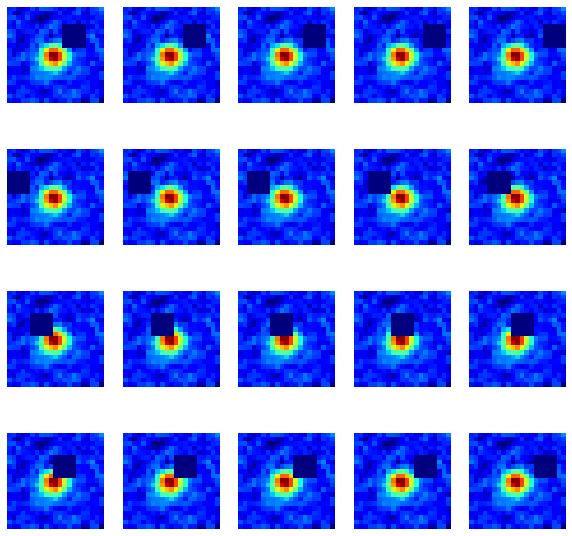

In [14]:
### testing out the occlusion generator class
x=x_train_all[3, :, :, 3]

occ = OcclusionGenerator(x, 5, 1, False)
occList = []
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(100):
    occList.append(occ.flow()[0])
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(occList[i+80], cmap='jet'); plt.axis("off")
plt.show()
#print(occList[i].shape)
del occ, x ,occList

In [15]:
# this function takes a list of heatmaps and merges them into one single heatmap
def post_process(heatmap):

    # postprocessing
    total = heatmap[0]
    for val in heatmap[1:]:
        total = total + val
    
    return total

In [16]:
#### This is the meat of the program. It generates the heatmap for the given image location ####
model = load_model('super_nova_class.model')
def gen_heatmap(model, fileloc, label, boxsize, step, verbose=True, savetodisk=False, batch=10, index=3):
  # load up image

    img=preprocessar_2d(fileloc[index])
    if verbose:
        plt.imshow(img); plt.axis("off")
        plt.show()
    
    
    r_img= fileloc[index]
    
    # classify image (w/o occlusions)   


    img_pred=to_4_axis(r_img)
    preds = model.predict(img_pred)
    correct_class_index = np.argmax(preds)

    # load correct label 

    correct_class_label = label[index]
    if verbose:
        print ('\n\n\ncorrect_class_label:', correct_class_label, '\n\n\n') 

    # generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)

    # scores of occluded image
    heatmap = []
    index = 0
    
    while True:

        # get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=batch)

        if x is not None:

            #predict 
            op = model.predict(np.expand_dims(x, axis=-1))

            #unpack prediction values 
            for i in range(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i] 
                scoremap = np.zeros((27,27))
                scoremap[r : r+occ.boxsize, c : c+occ.boxsize] = score
                heatmap.append(scoremap)

            if verbose:
                print ('..minibatch completed')
        else:
            break

    if savetodisk:
        #save heatmap to disk 
        
        f = open("heatmap", 'wb')
        pickle.dump(heatmap, f)
        f.close()

    return heatmap, correct_class_index, correct_class_label






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(27, 27, 1)
----> (27, 27)


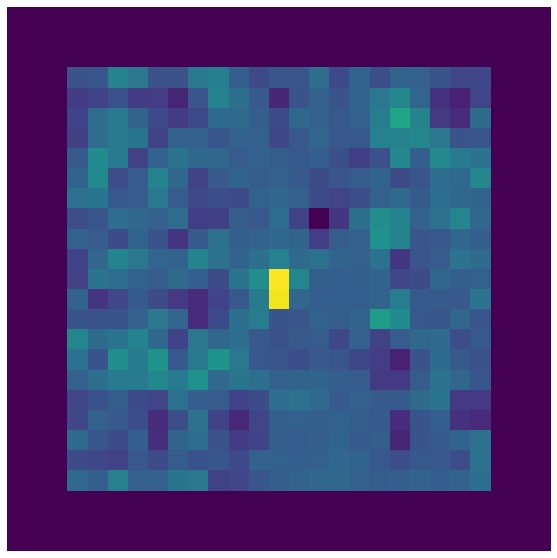




correct_class_label: 0 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..

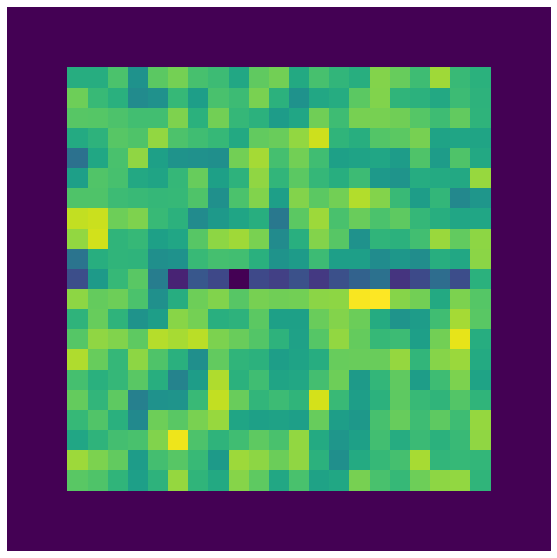




correct_class_label: 0 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..

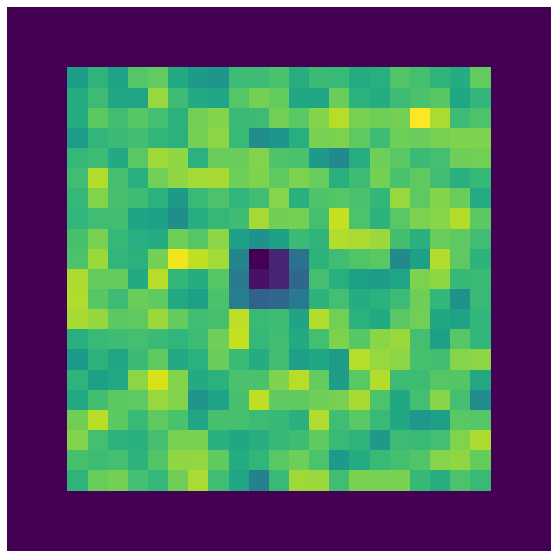




correct_class_label: 0 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..

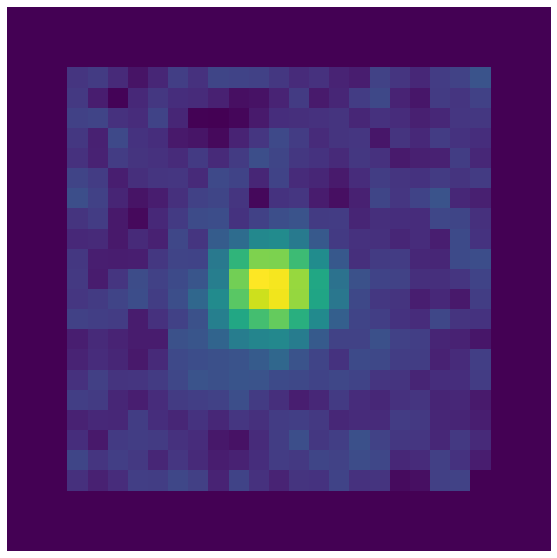




correct_class_label: 1 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..

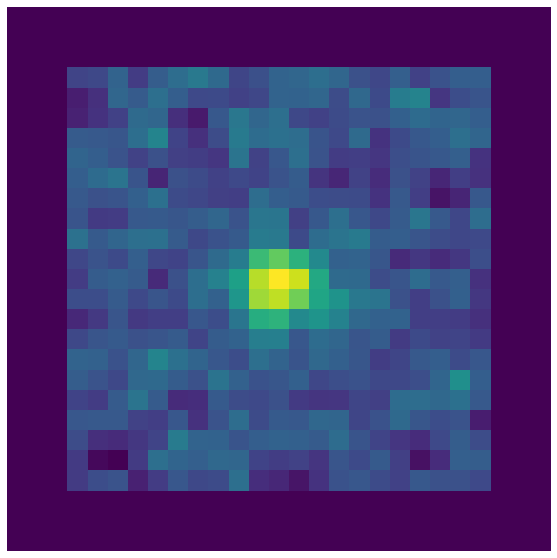




correct_class_label: 1 



..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..minibatch completed
..

In [18]:
# run the program on image

total=5


n_novas=0
n_no_novas=0
index_=0

to_save=[]
stack_images=[]

for index_ in range(total):
    t_i = time.time()


    heatmapList, index, label = gen_heatmap(model, r_x_train, y_train ,  3, 1, True, False, batch=10, index=index_)
    processed   = post_process(heatmapList)
    processed = normalize(processed)
    processed = processed[3:24, 3:24]

    #print("Time elapsed %.2f minutes" % ((time.time()-t_i)/60.0))
    print("\n\n\nTime elapsed %.3f segundos" % (time.time()-t_i))
    if(y_train[index_]==1 and n_novas<20000):
        stack_images.append(processed)
        n_novas+=1
        print("n novas stored:", n_novas)
    if(y_train[index_]==0 and n_no_novas<20000):
        stack_images.append(processed)
        n_no_novas+=1
        print("n no novas stored:", n_no_novas)

sp=np.array(stack_images).reshape(-1, 21, 21, 1)
print("\n\nimage shape", sp.shape )

to_save={"image":sp, "label":y_train[:total]}

f = open("OCmaps.pkl", 'wb')
pickle.dump(to_save, f)
f.close()

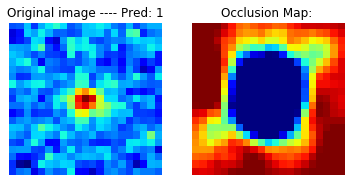

image shape: (21, 21)
processed shape: (21, 21)


In [19]:
%matplotlib inline

img=x_train_[index_]

plt.subplot(121)
plt.imshow(img, cmap='jet')                #[2:19, 2:19])
plt.axis("off")
plt.title("Original image ---- Pred: "+ str(label) )
plt.subplot(122)
plt.imshow(processed, cmap='jet')#[2:25, 2:25])              #[2:19, 2:19])
plt.title("Occlusion Map: ")
plt.axis("off")

plt.show()
print('image shape:', img.shape)
print('processed shape:', processed.shape)

In [20]:
print('       ESTADISTICAS OCCLUSION MAP      \n')
print('Valor máximo :', processed.max())
print('Valor mínimo :', processed.min())
print('Valor promedio :', processed.mean())
print('Valor varianza :', processed.var())
print('Valor desviación standar :', processed.std())

       ESTADISTICAS OCCLUSION MAP      

Valor máximo : 1.0
Valor mínimo : 0.0
Valor promedio : 0.6233753298239015
Valor varianza : 0.144732409249082
Valor desviación standar : 0.380437129167333


shape de mapas de oclusion: (5, 21, 21, 1)
(21, 21, 1)
----> (21, 21)
Nº labels:  5


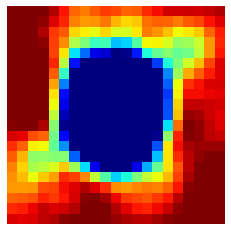

In [23]:
%matplotlib inline

imagem=4      #Choose image to visualize


archivo_occluded = open('OCmaps.pkl',"rb")
example_dict= pickle.load(archivo_occluded)



img=example_dict["image"]

print("shape de mapas de oclusion:", img.shape)

img=preprocessar_2d(img[imagem])


labelOcc=example_dict["label"]

print("Nº labels: ", labelOcc.shape[0])


plt.imshow(img, cmap='jet')                #[2:19, 2:19])
plt.axis("off")


plt.show()


